In [1]:
%matplotlib inline


Surface Obs Regional Plot
=====================

This exercise creates a surface observsation station plot for the state of Colorado, using both METAR (datatype *obs*) and Synoptic (datatype *sfcobs*). Because we are using the AWIPS Map Database for state and county boundaries, there is no use of Cartopy `cfeature` in this exercise.

In [2]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
from metpy.units import units
from metpy.calc import wind_components
from metpy.plots import (simple_layout, StationPlot,
                         StationPlotLayout, wx_code_map)

def get_cloud_cover(code):
    if 'OVC' in code:
        return 1.0
    elif 'BKN' in code:
        return 6.0/8.0
    elif 'SCT' in code:
        return 4.0/8.0
    elif 'FEW' in code:
        return 2.0/8.0
    else:
        return 0

In [3]:
# EDEX request for a single state
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.states')
request.addIdentifier('state', 'FL')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('state','name','lat','lon')
response = DataAccessLayer.getGeometryData(request)
record = response[0]
print("Found " + str(len(response)) + " MultiPolygon")
state={}
state['name'] = record.getString('name')
state['state'] = record.getString('state')
state['lat'] = record.getNumber('lat')
state['lon'] = record.getNumber('lon')
#state['geom'] = record.getGeometry()
state['bounds'] = record.getGeometry().bounds
print(state['name'], state['state'], state['lat'], state['lon'], state['bounds'])
print()

# EDEX request for multiple states
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.states')
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'state')
request.setParameters('state','name','lat','lon')
request.setLocationNames('FL','GA','MS','AL','SC','LA')
response = DataAccessLayer.getGeometryData(request)
print("Found " + str(len(response)) + " MultiPolygons")

# Append each geometry to a numpy array
states = np.array([])
for ob in response:
    print(ob.getString('name'), ob.getString('state'), ob.getNumber('lat'), ob.getNumber('lon'))
    states = np.append(states,ob.getGeometry())

Found 1 MultiPolygon
Florida FL 28.67402 -82.50934 (-87.63429260299995, 24.521051616000022, -80.03199876199994, 31.001012802000048)

Found 6 MultiPolygons
Florida FL 28.67402 -82.50934
Georgia GA 32.65155 -83.44848
Louisiana LA 31.0891 -92.02905
Alabama AL 32.79354 -86.82676
Mississippi MS 32.75201 -89.66553
South Carolina SC 33.93574 -80.89899


Now make sure we can plot the states with a lat/lon grid. 

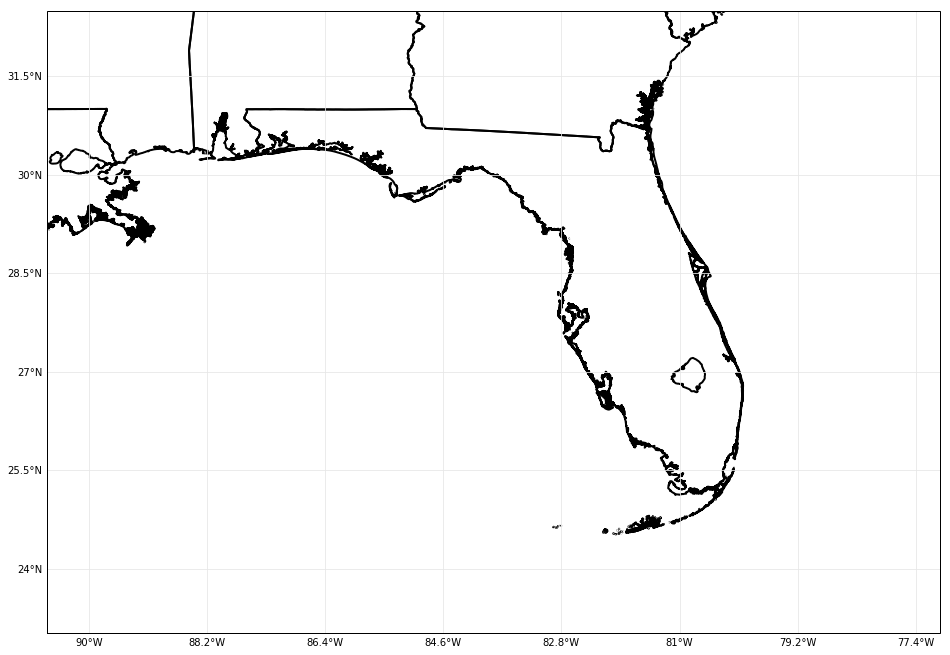

In [4]:
def make_map(bbox, proj=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=proj))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# buffer our bounds by +/i degrees lat/lon
bounds = state['bounds']
bbox=[bounds[0]-3,bounds[2]+3,bounds[1]-1.5,bounds[3]+1.5]

fig, ax = make_map(bbox=bbox)
shape_feature = ShapelyFeature(states,ccrs.PlateCarree(), 
                    facecolor='none', linestyle="-",edgecolor='#000000',linewidth=2)
ax.add_feature(shape_feature)

## Plot METAR

Here we use a spatial envelope to limit the request to the boundary or our plot.  Without such a filter you may be requesting many tens of thousands of records.

In [5]:
from shapely.geometry import Polygon
# Create envelope geometry
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])

# New obs request
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("obs", envelope=envelope)
availableProducts = DataAccessLayer.getAvailableParameters(request)
single_value_params = ["timeObs", "stationName", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
params = single_value_params + multi_value_params
request.setParameters(*(params))

# Time range
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 60)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
# function getMetarObs was added in python-awips 18.1.4
obs = DataAccessLayer.getMetarObs(response)
print("Found " + str(len(response)) + " records")

Found 2448 records


Next grab the simple variables out of the data we have (attaching correct units), and
put them into a dictionary that we will hand the plotting function later:

- Get wind components from speed and direction
- Convert cloud fraction values to integer codes [0 - 8]
- Map METAR weather codes to WMO codes for weather symbols

In [6]:
data = dict()
data['stid'] = np.array(obs['stationName'])
data['latitude']  = np.array(obs['latitude'])
data['longitude'] = np.array(obs['longitude'])
tmp = np.array(obs['temperature'], dtype=float)
dpt = np.array(obs['dewpoint'], dtype=float)
tmp[tmp == -9999.0] = 'nan'
dpt[dpt == -9999.] = 'nan' 
data['air_temperature'] = tmp * units.degC
data['dew_point_temperature'] = dpt * units.degC
data['air_pressure_at_sea_level'] = np.array(obs['seaLevelPress'])* units('mbar')
direction = np.array(obs['windDir'])
direction[direction == -9999.0] = 'nan'
u, v = wind_components(np.array(obs['windSpeed']) * units('knots'),
                           direction * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v
data['cloud_coverage'] = [int(get_cloud_cover(x)*8) for x in obs['skyCover']]
data['present_weather'] = obs['presWeather']

## MetPy Surface Obs Plot

/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


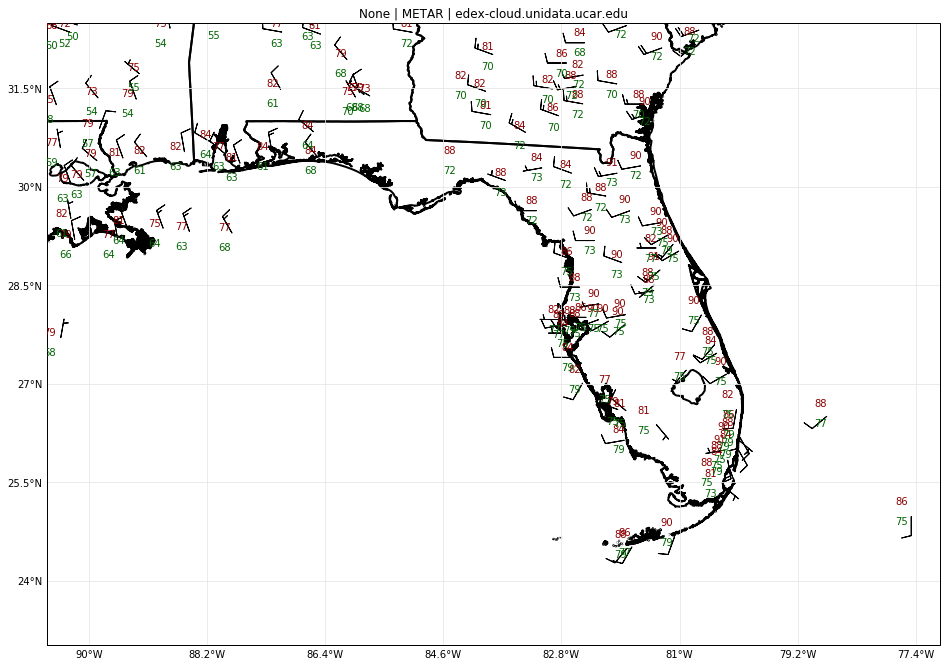

In [7]:
proj = ccrs.LambertConformal(central_longitude=state['lon'], central_latitude=state['lat'],
                             standard_parallels=[35])
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degF', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degF', color='darkgreen')
custom_layout.add_value('E', 'precipitation', fmt='0.1f', units='inch', color='blue')
ax.set_title(str(ob.getDataTime()) + " | METAR | " + edexServer)
stationplot = StationPlot(ax, data['longitude'], data['latitude'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)
custom_layout.plot(stationplot, data)
fig

In [8]:
# New sfcobs/SYNOP request
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("sfcobs", envelope=envelope)
availableProducts = DataAccessLayer.getAvailableParameters(request)
# (sfcobs) uses stationId, while (obs) uses stationName,
# the rest of these parameters are the same.
single_value_params = ["timeObs", "stationId", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
pres_weather, sky_cov, sky_layer_base = [],[],[]
params = single_value_params + multi_value_params
request.setParameters(*(params))

# Time range
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 60)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
# function getSynopticObs was added in python-awips 18.1.4
sfcobs = DataAccessLayer.getSynopticObs(response)
print("Found " + str(len(response)) + " records")

Found 337 records


In [9]:
data = dict()
data['stid'] = np.array(sfcobs['stationId'])
data['lat']  = np.array(sfcobs['latitude'])
data['lon'] = np.array(sfcobs['longitude'])

# Synop/sfcobs temps are stored in kelvin (degC for METAR/obs)
tmp = np.array(sfcobs['temperature'], dtype=float)
dpt = np.array(sfcobs['dewpoint'], dtype=float)
direction = np.array(sfcobs['windDir'])
# Account for missing values
tmp[tmp == -9999.0] = 'nan'
dpt[dpt == -9999.] = 'nan'
direction[direction == -9999.0] = 'nan'

data['air_temperature'] = tmp * units.kelvin
data['dew_point_temperature'] = dpt * units.kelvin
data['air_pressure_at_sea_level'] = np.array(sfcobs['seaLevelPress'])* units('mbar')
try:
    data['eastward_wind'], data['northward_wind'] = wind_components(
        np.array(sfcobs['windSpeed']) * units('knots'),direction * units.degree)
    data['present_weather'] = sfcobs['presWeather']
except ValueError:
    pass

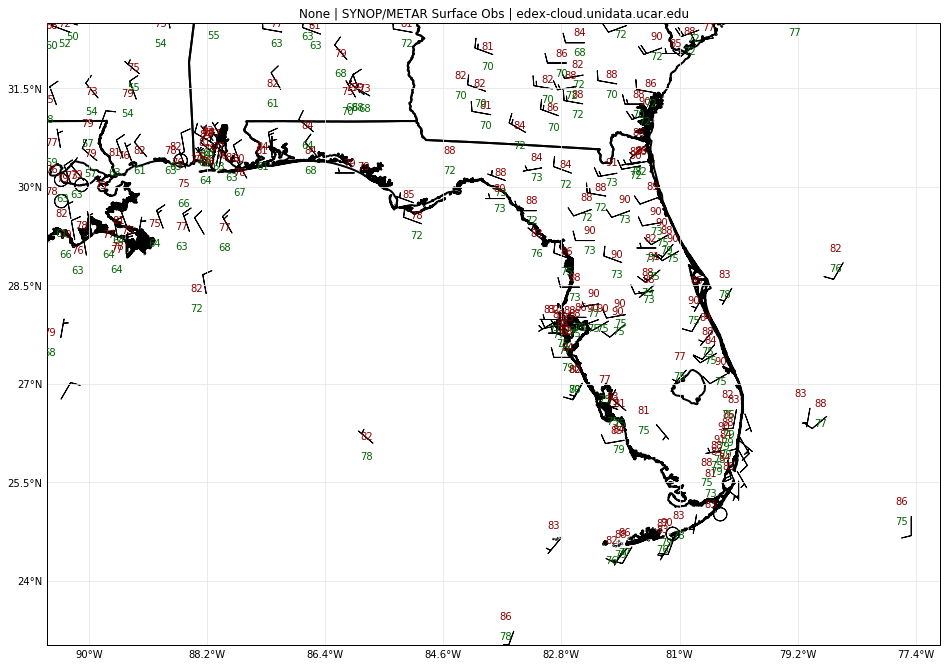

In [10]:
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degF', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degF', color='darkgreen')
custom_layout.add_value('E', 'precipitation', fmt='0.1f', units='inch', color='blue')
ax.set_title(str(ob.getDataTime()) + " | SYNOP/METAR Surface Obs | " + edexServer)
stationplot = StationPlot(ax, data['lon'], data['lat'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)
custom_layout.plot(stationplot, data)
fig